# DDPG + PPO cooperation :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 70

### 3. Setup dummies ( unused feats in this environment )

In [3]:
class RandPrio: # for prio replay, but we abandon that for now
    def weight(self, s, n, a):
        return np.asarray([random.random() for _ in range(a.reshape(-1).shape[0])]).reshape(a.shape)

    def update(self, s, n, a):
        pass

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)

### 4. Set model wrappers

In [4]:
def Actor(encoder, ddpg=True):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    action_fn = lambda x: torch.tanh(x) * (3. if ddpg else 1.)
    return lambda: model.ActorFactory(nes_layers, action_fn, action_size=ACTION_SIZE, ddpg=ddpg)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if 0 == total % 3:
        # OK we move DDPG towards PPO safe zone
        bot.sync_explorer(0, 1, [])
        bot.sync_target(0, 1, [])
        # NOW we move PPO towards wilder DDPG exploration
        bot.sync_explorer(1, 0, [])
        bot.sync_target(1, 0, [])
    if test_scores is not None:
        print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))
        
def debugout(bot, scores, actions):
    pass

### 5. Setup && run agent/bot

In [5]:
PPO_LOOP = 3
bs = 2048
learning_delay = MAX_STEPS * PPO_LOOP

ppo_n_envs = 14 # rest ( 6 ) ddpg for driving exploration beyond safe zone
ddpg_n_envs = TOTAL_ENV - ppo_n_envs # rest will be PPO for estimating safe zone to go
    
#rand_prio = RandPrio()

ReplayBuffer = cross_exp_buffer(TOTAL_ENV*250) # without need to recalc feats again and again, aka small one

replay_ppo = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=learning_delay * ppo_n_envs * 2, select_count=40, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=0)

replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=MAX_STEPS * ddpg_n_envs * 100, select_count=4, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=4)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: DDPG
            ddpg=True,
            count=ddpg_n_envs, n_groups=ddpg_n_envs, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_coop_v2_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=128,
            sync_delta=5, learning_delay=N_STEP * 3, learning_repeat=TOTAL_ENV * 5,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=None, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=3e-4, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=False, prob_treshold=None),
        BrainDescription( # shadow :: PPO
            ddpg=False,
            count=ppo_n_envs, n_groups=ppo_n_envs, Actor=Actor(encoder, False), Critic=Critic(encoder),
            model_path="x_coop_v2_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ppo, batch_size=bs,
            sync_delta=3, learning_delay=learning_delay, learning_repeat=TOTAL_ENV * 10,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=2e-1, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=3e-4, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=True, prob_treshold=(7e-3, 1.7)),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=1,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        n_step=N_STEP, floating_step=True, gamma=.99,

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=1,
        gae=True, gae_tau=.95,
        freeze_delta=10, freeze_count=6,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 3,
        eval_limit=10, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

bot.sync_explorer(1, 0, [])
bot.sync_target(1, 0, [])

scores = env.start(callback, debugout)
losses_1 = bot.brains[0].get_losses()
losses_2 = bot.brains[1].get_losses()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[    2>   110:: 0] steps =   39, max_step =  71/ 70, reward=-0.004500 <action=[ 1.0893141  -0.29295922  1.85918362  1.57307904]>                    

C:\Users\qilin\Desktop\breaktrough\projecto\alchemy\agent.py:163: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  batch = np.vstack(zip(*self._regroup_for_replay()))
C:\Users\qilin\Desktop\breaktrough\projecto\alchemy\agent.py:201: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(zip(*batch))
C:\Users\qilin\Desktop\breaktrough\projecto\utils\policy.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  td_error = torch.tensor(td_targets).to(qa.device) - qa


[   20>  1419:: 0] steps =   70, max_step =  71/ 70, reward=0.001778 <action=[ 2.9981848   2.9981643   2.99850759 -2.11738453]>                                     
	==> test round with  1 [1.1409999744966635] 0.0019444444444444414
[   40>  2839:: 0] steps =   70, max_step =  71/ 70, reward=0.031000 <action=[-2.98336513  2.99904906 -2.99999997  2.9990181 ]>                                    
	==> test round with  1 [2.50049994410946] 0.031277777777777765
[   60>  4259:: 0] steps =   70, max_step =  71/ 70, reward=0.057444 <action=[-3.         -2.46129862 -2.9999998  -2.90685527]>                                    
	==> test round with  1 [4.158499907050273] 0.05855555555555556
[   80>  5679:: 0] steps =   70, max_step =  71/ 70, reward=0.063444 <action=[-2.98551411  3.          2.73657554  3.        ]>                                    
	==> test round with  1 [7.613999829813853] 0.06494444444444444
[  100>  7099:: 0] steps =   70, max_step =  71/ 70, reward=0.092389 <action=[-2.999

[  760> 53959:: 0] steps =   70, max_step =  71/ 70, reward=0.168556 <action=[-2.99999989 -3.          3.          3.        ]>                     
	==> test round with  1 [26.350999411009287] 0.17150000000000004
[  780> 55379:: 0] steps =   70, max_step =  71/ 70, reward=0.177556 <action=[-3.  3.  3.  3.]>                    2.98592837]>                     
	==> test round with  1 [24.685499448236136] 0.1806666666666667
[  800> 56799:: 0] steps =   70, max_step =  71/ 70, reward=0.165056 <action=[-3.          3.          3.          2.99007244]>                                
 environment solved!  32.80144926683043
[32.35649927677594, 33.84999924339359, 31.618499293271366, 33.840499243605834, 32.85199926570054, 33.690499246958616, 32.530499272886665, 33.59849924901496, 31.865999287739378, 31.811499288957485]


In [6]:
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex_1 = losses_1
losses_1 = np.vstack(losses_1)[::len(losses_1)//200]
losses_ex_2 = losses_2
losses_2 = np.vstack(losses_2)[::len(losses_2)//200]

### 4. Plot reward + loss

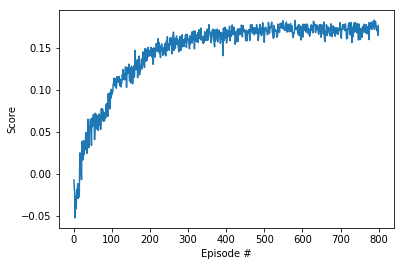

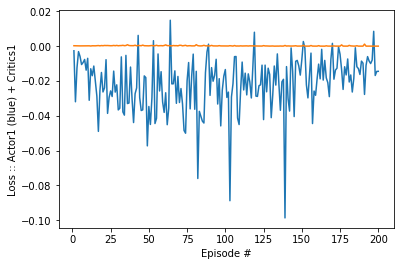

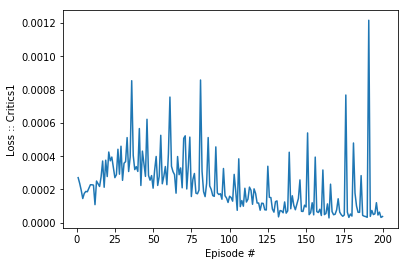

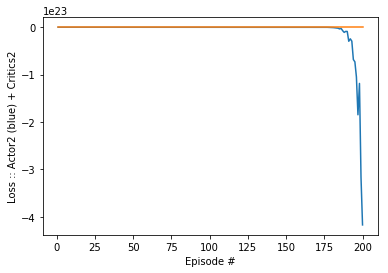

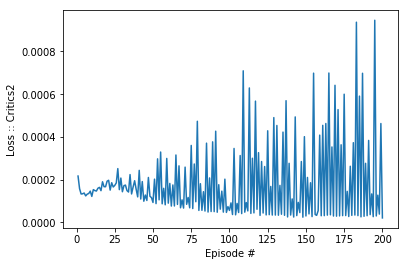

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1)
plt.ylabel('Loss :: Actor1 (blue) + Critics1')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1[:, 1:])
plt.ylabel('Loss :: Critics1')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2)
plt.ylabel('Loss :: Actor2 (blue) + Critics2')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2[:, 1:])
plt.ylabel('Loss :: Critics2')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [8]:
for i in range(2):
    bot.sync_target(i, i, [])
    bot.sync_explorer(i, i, [])

### 5. Test visuals - TARGET


 environment solved!  32.71779926870018
[33.285499256011114, 32.996499262470785, 31.229499301966296, 32.18649928057567, 32.44599927477533, 32.99799926243724, 32.515499273221906, 32.74449926810341, 34.079999238252675, 32.69599926918741]

 environment solved!  33.50934925100769
[33.82849924387413, 34.274499233905324, 34.62849922599275, 35.098499215487436, 32.99099926259372, 32.601999271288484, 33.6834992471151, 33.245499256905205, 33.073499260749664, 31.667999292165113]

 environment solved!  33.473099251817914
[33.25299925673763, 32.67249926971269, 32.7364992682822, 33.41249925317242, 33.70899924654509, 34.34799923226242, 32.9144992643036, 33.30999925546352, 34.01499923970545, 34.359999231994166]

 environment solved!  33.215699257571245
[32.59099927153437, 32.06249928334729, 33.050499261263695, 33.9199992418289, 32.832499266136416, 32.61199927106496, 33.3974992535077, 35.11699921507396, 34.137999236956304, 32.43599927499888]

 environment solved!  33.571099249627466
[34.37549923164779

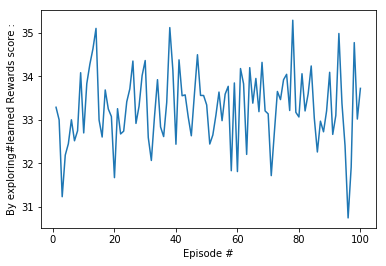

In [9]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER ( target network )


 environment solved!  33.1856992582418
[32.83149926615876, 32.64049927042798, 32.23849927941338, 32.23049927959216, 34.58149922704331, 33.5974992490373, 33.98649924034248, 32.353499276842946, 33.437999252602495, 33.95899924095723]

 environment solved!  33.0338992616348
[33.262499256525224, 33.99949924005193, 32.342499277088834, 33.38599925376471, 33.770999245159345, 32.39349927594886, 32.19099928047509, 33.37049925411123, 33.271499256324034, 32.35099927689879]

 environment solved!  33.00254926233553
[33.49699925128376, 32.446999274753026, 33.646999247930886, 32.70649926895272, 32.514499273244276, 32.76899926755576, 32.55149927241731, 32.66749926982454, 33.67599924728277, 33.5494992501102]

 environment solved!  33.404049253361315
[34.35299923215069, 33.142499259207376, 33.32499925512826, 32.76649926761171, 33.0919992603361, 33.20049925791101, 33.83849924365059, 33.632499248255044, 33.88249924266712, 32.80749926669521]

 environment solved!  32.96584926315584
[33.58199924938381, 30.1

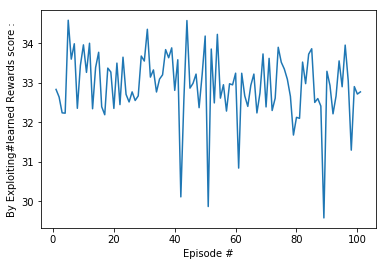

In [10]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[1].ac_target

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 

### 7. Test visuals - EXPLORER ( explorer network )


 environment solved!  34.427499230485424
[33.88249924266715, 33.96199924089012, 33.881499242689436, 33.254499256703994, 33.575999249517864, 35.40499920863665, 34.211499235313426, 36.07099919375033, 35.36499920953068, 34.66599922515457]

 environment solved!  34.78249922255061
[35.956499196309665, 36.084999193437596, 34.54449922787023, 35.06399921625858, 35.388499209005474, 34.77849922264004, 35.62299920376413, 32.71749926870682, 33.62499924842281, 34.04249923909085]

 environment solved!  34.5727492272389
[35.816999199427876, 33.00699926223602, 35.02049921723094, 35.41649920837973, 35.45199920758617, 33.20049925791097, 33.54399925023316, 33.41299925316124, 36.46349918497742, 34.393499231245485]

 environment solved!  34.52409922832631
[34.52199922837322, 35.16799921393414, 33.636999248154474, 33.399999253451824, 34.71199922412634, 35.01849921727558, 33.86999924294654, 35.22099921274947, 34.71799922399234, 34.97449921825912]

 environment solved!  34.61849922621627
[33.37649925397705, 

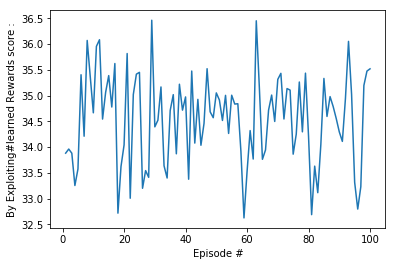

In [11]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[1].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 